In [1]:
# Importings base libraries
import os;
import pandas as pd; 
import numpy as np;
import librosa;
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

# Models
import sklearn.model_selection # train_test_split
import sklearn.discriminant_analysis # LinearDiscriminantAnalysis
import sklearn.naive_bayes  # GaussianNB

seed = 42

In [2]:
# Working with data - Those functions are helpers to work with the final DataFrame

def get_audio_and_sampling_rate_from_df(df, row_index, asNumpyArray = True ):
    data, sampling_rate, label = get_data_sample_rate_and_legend_from_df(df, row_index, asNumpyArray)
    return(data, sampling_rate)

def get_data_sampling_rate_and_legend_from_df(df, row_index, asNumpyArray = True):
    data = df.iloc[ row_index , df.columns.get_loc(0): ].astype('float64')
    if(asNumpyArray):
        data = data.values
    sample_rate = df.loc[: , "sr"].iloc[row_index]
    label = df.loc[ : , 'label'].iloc[row_index]
    return(data, sample_rate, label)
    
def show_data(df, row):
    # Retrieve information from DF
    audio_data, sampling_rate, label = get_data_sample_rate_and_legend_from_df(df, row)
    
    # Print some stats and display the sound
    print(f"{label}({librosa.get_duration(audio_data, sr=sampling_rate)} sec)")
    ipd.display(ipd.Audio(audio_data, rate=sampling_rate))
    
    print("\n")
    # Make plots
    X = librosa.stft(audio_data)
    Xdb = librosa.amplitude_to_db(abs(X))

    plt.figure(figsize=(8, 16), dpi= 80, facecolor='w', edgecolor='k')

    plt.subplot(3, 1, 1)
    plt.title("Wave")
    librosa.display.waveplot(audio_data, sr=sampling_rate, x_axis="time")

    plt.subplot(3, 1, 2)
    plt.title("MEL")
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis="time", y_axis="mel")

    plt.subplot(3, 1, 3)
    plt.title("HZ")
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis="time", y_axis="hz")

    print("Audio")
    ipd.Audio(audio_data, rate = sampling_rate)

In [3]:
# Will read from the pickle file - use ingestion when ready
training_data_path   = os.path.join(".","dados","training_data.pickle")
validation_data_path = os.path.join(".","dados","validation_data.pickle")

In [4]:
# Will read only part of the data
training = pd.read_pickle(training_data_path)

In [5]:
training.shape

(1414, 88204)

In [58]:
print(f"Shape: {training.shape} \n"+
      f"Número de Audios: {training.shape[0]} \n"+
      f"Número de Audios/4: {training.shape[0]/4}\n" +
      f"Numero De Arquivos Lidos: {len(training.original_file.unique())}\n"+
      f"Numero De Audios Esperados: {4 * len(training.original_file.unique())}\n"+
      f"Diferença Entre número de Arquivos: { 4 * len(training.original_file.unique()) - training.shape[0]}\n"+
      f"Diferença % Entre número de Arquivos: { 100*(4 * len(training.original_file.unique()) - training.shape[0])/training.shape[0] :.2f}%\n"+
      f"Sample Rates: {training.sr.unique()}")


Shape: (1414, 88204) 
Número de Audios: 1414 
Número de Audios/4: 353.5
Numero De Arquivos Lidos: 356
Numero De Audios Esperados: 1424
Diferença Entre número de Arquivos: 10
Diferença % Entre número de Arquivos: 0.71%
Sample Rates: [44100]


In [33]:
contagem_audios = training["original_file"].value_counts()
contagem_audios[contagem_audios != 4]

mdn6    3
7x6a    3
6add    3
cdbd    3
ca7m    3
xbnb    3
dhcd    3
haa6    3
xxxm    3
cdbc    3
Name: original_file, dtype: int64

In [43]:
missing_files = contagem_audios[contagem_audios != 4].index
training[training['original_file'].isin(missing_files) ] . loc[ : ,["label","original_file"]]

,label,original_file
48,6,6add
49,a,6add
50,d,6add
291,7,7x6a
292,x,7x6a
293,6,7x6a
586,c,ca7m
587,a,ca7m
588,7,ca7m
629,c,cdbc


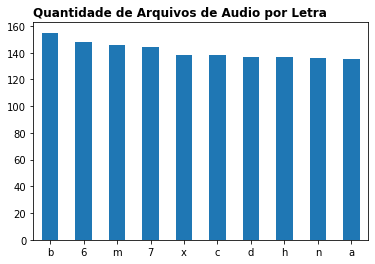

In [54]:
plt.title("Quantidade de Arquivos de Audio por Letra", loc="left", fontdict={'fontweight':"bold"})
training.label.value_counts().plot(kind="bar", rot=0)

In [53]:
training.label.value_counts()

b    155
6    148
m    146
7    144
x    138
c    138
d    137
h    137
n    136
a    135
Name: label, dtype: int64

In [11]:
def extract_features_and_labels(df):
    features = df.iloc[ : , df.columns.get_loc(0): ]
    labels = df.loc[ : , "label"]
    return(features, labels)

In [67]:
train, test = sklearn.model_selection.train_test_split(training,
                                                 test_size=0.3, 
                                                 random_state=seed )

x_train, y_train = extract_features_and_labels(train)
x_test, y_test = extract_features_and_labels(test)

In [68]:
# Encoding train
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(np.concatenate((y_train, y_test), axis=0))
y_train_int = label_encoder.transform(y_train)
y_test_int = label_encoder.transform(y_test)
#one_hot_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)

In [69]:
# Using Linear Discriminant Analysis
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(x_train, y_train_int)

D:\program_files\Miniconda3\envs\md\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [70]:
# Training Accuracy
predicoes = lda.predict(x_train)
corretas = np.equal(predicoes, y_train_int)
erradas  = np.logical_not((corretas))

n_corretas = sum(corretas)
n_erradas = sum(erradas)

n_corretas/(n_corretas+n_erradas)

0.9716885743174924

In [71]:
# Test Accuracy 
predicoes_lda = lda.predict(x_test)
corretas = np.equal(predicoes_lda, y_test_int)
erradas  = np.logical_not((corretas))

n_corretas = sum(corretas)
n_erradas = sum(erradas)



In [72]:
print(f"Acurácia do Linear Discriminant Analysis (Teste): {100*n_corretas/(n_corretas+n_erradas):.2f}%")

Acurácia do Linear Discriminant Analysis (Teste): 10.12%


In [73]:
# Using naive bayes
nb  =  sklearn.naive_bayes.GaussianNB()
nb.fit(x_train, y_train_int)

GaussianNB(priors=None, var_smoothing=1e-09)

In [74]:
# Training Accuracy
predicoes = nb.predict(x_train)
corretas = np.equal(predicoes, y_train_int)
erradas  = np.logical_not((corretas))

n_corretas = sum(corretas)
n_erradas = sum(erradas)

In [75]:
# Test Accuracy 
predicoes_nb = nb.predict(x_test)
corretas = np.equal(predicoes_nb, y_test_int)
erradas  = np.logical_not((corretas))

n_corretas = sum(corretas)
n_erradas = sum(erradas)

n_corretas/(n_corretas+n_erradas)

0.11294117647058824

In [76]:
print(f"Acurácia do Naive Bayes (Teste): {100*n_corretas/(n_corretas+n_erradas):.2f}%")

Acurácia do Naive Bayes (Teste): 11.29%
